In [1]:
# colab settings
from google.colab import drive
import os

# This will prompt for authorization.
drive.mount('drive', force_remount=True)

Mounted at drive


In [ ]:
!git clone --quiet https://github.com/Aurel37/data_challenge_kernel_method.git

In [2]:
persistent_storage = 'drive/MyDrive/MVA/kernel/'

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

Xtr = np.array(pd.read_csv(persistent_storage + 'Xtr.csv',header=None,sep=',',usecols=range(3072)))
Xte = np.array(pd.read_csv(persistent_storage + 'Xte.csv',header=None,sep=',',usecols=range(3072)))
Ytr = np.array(pd.read_csv(persistent_storage + 'Ytr.csv',sep=',',usecols=[1])).squeeze()

# define your learning algorithm here
# for instance, define an object called ``classifier''  
# classifier.train(Ytr,Xtr)


# predict on the test data
# for instance, Yte = classifier.fit(Xte)

# next

print(Xte[0, :])

[ 0.02131679 -0.02918767 -0.0217463  ... -0.0072958  -0.02088945
 -0.02422281]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


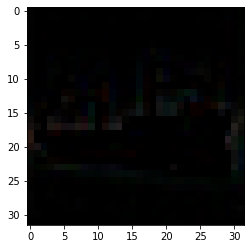

In [ ]:
def display_pict(image):
    formatted = np.zeros((32, 32, 3))
    formatted[:,:,0] = np.reshape(image[:1024], (32,32))
    formatted[:,:,1] = np.reshape(image[1024:2048], (32,32))
    formatted[:,:,2] = np.reshape(image[2048:3072], (32,32))
    plt.imshow(formatted)
display_pict(Xtr[0, :])

In [ ]:
# feature finder
# PCA ? GRadient truc ? 

In [ ]:
test = np.array([0, 3, 5, 4])


(1, 4)


ValueError: ignored

In [67]:
class DataLoader:

    def __init__(self, dataset, target, batch_size=1, shuffle=False):
        if not(target.shape[0] == dataset.shape[0]):
            raise ValueError("target and dataset must have same x-axis size")
        N = dataset.shape[0]
        self.dataset_raw = dataset.copy()
        self.target_raw = target.copy()
        if shuffle:
            arange = np.arange(N)
            self.dataset = np.split(dataset[arange, :], batch_size)
            self.target = np.split(target[arange], batch_size)
        else:
            self.dataset = np.split(dataset, batch_size)
            self.target = np.split(target, batch_size)
        self.n_batch = len(self.target)
        self.it = None
        self.batch_size = batch_size
        self.shuffle = shuffle
      
    def __iter__(self):
        self.it = -1
        return self

    def __next__(self):
        if self.it + 1 < self.n_batch:
            self.it += 1
            return self.dataset[self.it], self.target[self.it]
        else:
            raise StopIteration
    
    def copy(self):
        dataset = self.dataset_raw.copy()
        target = self.target_raw.copy()
        return DataLoader(dataset, target, self.batch_size, self.shuffle)

In [ ]:
from scipy.linalg import eigh

class KernelPCA:

    def __init__(self, dataloader, kernel, n_dim):
        self.dataloader = dataloader.copy()
        self.n_batch = dataloader.n_batch

        # kernel should be a function here
        self.kernel = kernel
        self.n_dim = n_dim
    
    def center_kernel(self, X):
        N, _ = X.shape
        kernel_mat = self.kernel(X, X)
        ones_N = 1/N*np.ones((N, N))
        return kernel_mat - ones_N@kernel_mat - kernel_mat@ones_N + ones_N@kernel_mat@ones_N
    
    def PCA(self, X):
        K = self.center_kernel(X)
        eigenvals, eigenvects = eigh(K)

        # remove the eigenvectors associated to 0
        # it's a sanity check, should never occur
        non_zero = eigenvals != 0
        eigenvals = eigenvals[non_zero]
        eigenvects = eigenvects[non_zero, :]

        # sort eigenvalues in descending order to retrieve 
        # the first n_dim eigenvect
        order_eigh = eigenvals.argsort()[::-1]
        order_eigh = order_eigh[:self.n_dim]

        alpha = eigenvects[order_eigh, :].T/np.sqrt(eigenvals[order_eigh])
        return np.dot(K, alpha)

    def project(self):
        for i in range(self.n_batch):
            self.dataloader.dataset[i] = self.PCA(self.dataloader.dataset[i])
        return self.dataloader

In [ ]:
dataloader = DataLoader(Xtr, Ytr, 500)

In [5]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
        #self.k = None
        
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        
        # difference between all vectors X and Y
        xmy = X[:, None, :] - Y[None, :, :]
        #self.k = xmy
        return np.exp(-1/2*np.square(np.linalg.norm(xmy, axis=2)/self.sigma))

In [ ]:
rbf = RBF(1)
rbf.kernel(Xtr, Xtr)

In [69]:
from scipy import optimize

class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
    
    def fit(self, X, y):
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        diag_y = np.zeros((N,N))
        for i in range(N):
            diag_y[i,i] = y[i]
        one = np.ones(N)
        K = self.kernel(X, X)
        # Lagrange dual problem
        
        def loss(alpha):
            return  -2*alpha.T@y+alpha.T@K@alpha

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return -2*y + 2*K@alpha

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: alpha.T@one    
        jac_eq = lambda alpha: one
        fun_ineq_0 = lambda alpha: -alpha*y + self.C*one
        jac_ineq_0 = lambda alpha:  -diag_y
        fun_ineq_1 = lambda alpha: alpha*y
        jac_ineq_1 = lambda alpha:  diag_y
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq_0 , 
                        'jac': jac_ineq_0}, 
                       {'type': 'ineq', 
                        'fun': fun_ineq_1, 
                        'jac': jac_ineq_1}, 
                      )

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x
        
        # support indices
        supportIndices = np.where(np.abs(self.alpha) > self.epsilon)  
        self.alpha = self.alpha[supportIndices]
        y_support = y[supportIndices]
        self.support = X[supportIndices] #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        
        K = self.kernel(self.support, self.support)
        
        # compute b
        
        # index of alpha_i to compute b using 
        # the complementary slackness conditions
        kkt_index = np.argmax((self.alpha > 0)*(self.alpha < y_support*self.C))
        self.b = y_support[kkt_index] - self.separating_function(np.array([self.support[kkt_index]]))
        
        # compute the norm of f
        self.norm_f = np.sqrt(self.alpha.T@K@self.alpha)
        
    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return  self.kernel(x, self.support)@self.alpha
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b > 0) - 1

In [ ]:
def train(batch_size, n_dim, kernel, param_kernel, n_class=10):
    kernel_func = kernel(param_kernel).kernel
    dataloader = DataLoader(Xtr, Ytr, batch_size)
    dataloader_pca = KernelPCA(dataloader, kernel_func, n_dim)
    SVMs = []
    for in range(n_class):
        